## Anomaly detection using time series classification approach

There are numerous techniques to detect anomalies in time series. Some of them are covered in tutirials for FedotIndustrial framework as far as it is designed solve this sort of task.

In this example we'd like to show you how to solve anomaly detection task using classification approach.

We will use randomly generated time series of univariate and multivariate types with anomaly labels.

This approach rely on construction of classification dataset based of time series and anomaly labels we have. The algorithm is designed so it will crop a time series into samples which are labeled as `anomaly` or `non_anomaly`, and then split this dataset into train and test parts which are ready to be fed into `FedotIndustrial` framework to solve time series classification task.

First, we need to import necessary for this particular example libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fedot_ind.api.main import FedotIndustrial
from fedot_ind.tools.synthetic.anomaly_generator import AnomalyGenerator
from fedot_ind.core.operation.transformation.splitter import TSSplitter

For this experiment we will use two time series:
- first one is randomly generated time series
- second one is data obtained from real equipment representing power consumption

For this purpose we will define an object of real time series data, obtained from ``.csv`` file, synthetic time series config and desired anomaly config.

It is worth to notice that ``synth_ts`` is a dictionary that may contain different parameters of time series depending on its type. Here are those types and corresponding examples of parameters:

- ``random_walk``: 'start_val': 36.6
- ``sin``: 'amplitude': 10, 'period': 500
- ``auto_regression``: 'ar_params': [0.5, -0.3, 0.2], 'initial_values': [0.5, 0.3, 0.2] or None
- ``smooth_normal``: 'window_size': 300

Anomaly config may contain hyperparameters of different types of anomalies. Every anomaly must be described with the following params:
- ``number`` – quantity of appearances
- ``level`` – anomaly level (the higher the level, the more significant the anomaly)
- ``min_anomaly_length`` – minimum length of anomaly
- ``max_anomaly_length`` – maximum length of anomaly

Additionaly some anomalies may have specific hyperparameters:

- ``noise_type`` – type of noise (``uniform``, ``gaussian`` or ``normal``)
- ``ar_params`` – parameters of autoregression (``List[float]``). Defines the coefficients of the autoregressive model. The number of coefficients determines the order of the autoregressive model.
- ``initial_values`` – initial values of autoregression (``List[float]``). Defines the initial values of the autoregressive model. The number of initial values must be equal to the number of coefficients of the autoregressive model.
- ``start_val`` – start value of random walk (``float``)
- ``amplitude`` – amplitude of sine wave (``float``)
- ``period`` – period of sine wave (``float``)
- ``window_size`` – window size of smooth normal (``int``)

In [2]:
real_time_series = pd.read_csv('power.csv', index_col=0)['Power']

synth_ts = {'ts_type': 'sin',
            'length': 1000,
            'amplitude': 10,
            'period': 500}

MAX_LENGTH = 20
MIN_LENGTH = 10
NUMBER = 6
anomaly_config = {'dip': {'level': 20,
                          'number': NUMBER,
                          'min_anomaly_length': MIN_LENGTH,
                          'max_anomaly_length': MAX_LENGTH},
                  'peak': {'level': 10,
                           'number': NUMBER,
                           'min_anomaly_length': MIN_LENGTH,
                           'max_anomaly_length': MAX_LENGTH},
                  'shift_trend_up': {'level': 10,
                                     'number': NUMBER,
                                     'min_anomaly_length': MIN_LENGTH,
                                     'max_anomaly_length': MAX_LENGTH},
                  'add_noise': {'level': 80,
                                'number': NUMBER,
                                'noise_type': 'uniform',
                                'min_anomaly_length': MIN_LENGTH,
                                'max_anomaly_length': MAX_LENGTH}
                  }

In [3]:
generator = AnomalyGenerator(config=anomaly_config)

### Synthetic time series

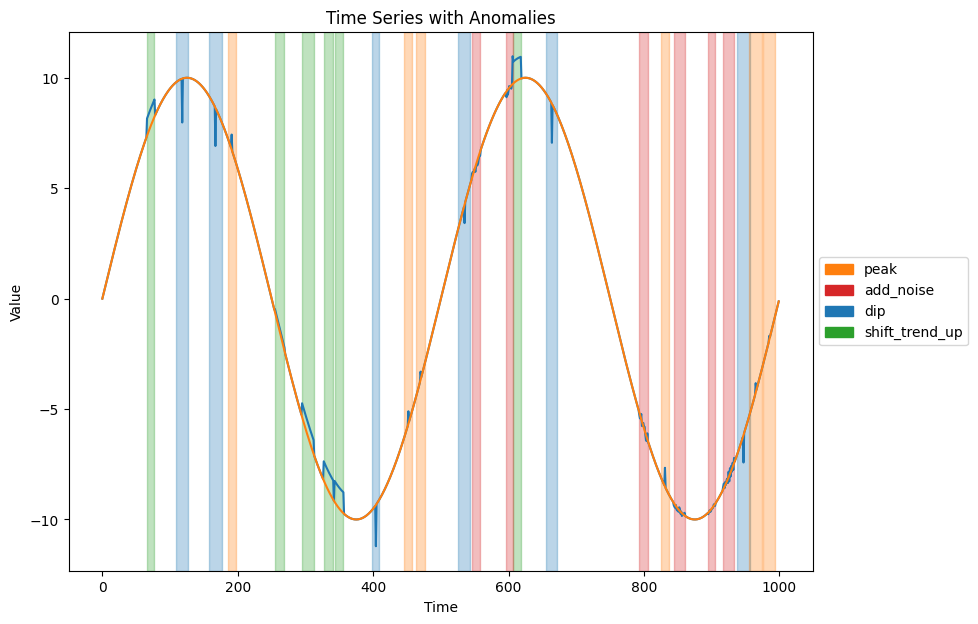

In [4]:
init_synth_ts, mod_synth_ts, synth_inters = generator.generate(time_series_data=synth_ts,
                                                               plot=True,
                                                               overlap=0.1)

Let's take a look at the generated time series and its anomalies more closely:

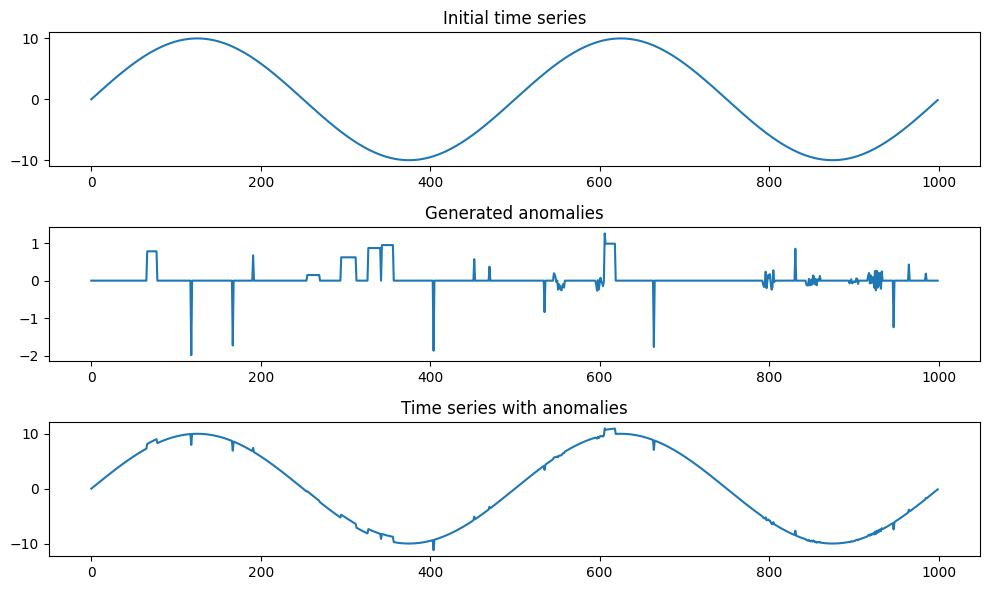

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
axs[0].plot(init_synth_ts)
axs[0].set_title('Initial time series')
axs[1].plot(mod_synth_ts-init_synth_ts)
axs[1].set_title('Generated anomalies')
axs[2].plot(mod_synth_ts)
axs[2].set_title('Time series with anomalies')
plt.tight_layout()
plt.show()

Also, we can take a look at the intervals of anomalies:

In [6]:
synth_inters

{'dip': '109:126, 656:671, 937:956, 399:409, 157:176, 526:543',
 'peak': '825:837, 955:974, 463:476, 446:457, 976:994, 185:197',
 'shift_trend_up': '66:77, 295:312, 343:356, 606:618, 327:341, 255:269',
 'add_noise': '793:806, 546:558, 844:860, 895:905, 596:606, 917:933'}

Now, as far as we have time series and anomaly labels, the `TSSplitter` class could be invited to our party. To do it all we need is to instantiate this class with three arguments:

- `time series` (univariate or multivariate in the form `List[time_series]`
- `anomaly_dict` - dictionary with labels of every anomaly class
- `strategy` - the way how dataset is going to formed.

Strategy could be of two types:

- `frequent` - it is when anomaly classes are preserved, but their intervals are transformed to the most frequent length
- `unique` – every combination of anomaly class and particular length are considered as unique anomaly. In this case the output of `split` method will be tuple of three objects: a list of unique anomaly names, list of train subsets and list of test subsets

In [7]:
splitter = TSSplitter(time_series=mod_synth_ts,
                      anomaly_dict=synth_inters,
                      strategy='frequent')

Then we need to call `split` method with two arguments which names are speak for themselfs:

- `plot` tells whether to produce visualisation of initial time series, anomalies and selected non-anomaly intervals
- `binarize` argument could be used in case when there is huge class imbalance and it is more appropriate to combine all anomaly classes into one rather that trying to distinguish them

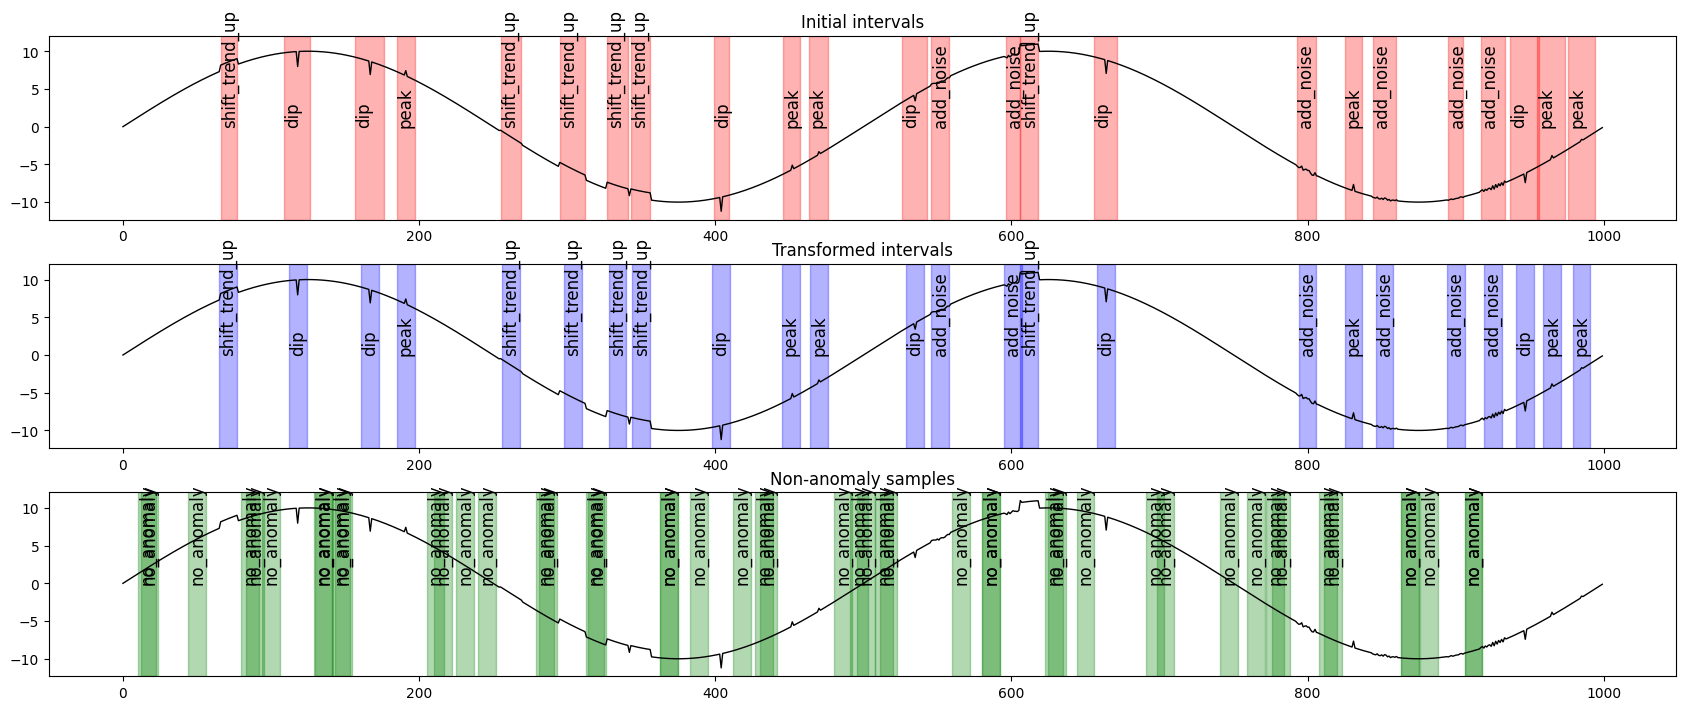

In [18]:
train_data, test_data = splitter.split(plot=True, 
                                       binarize=True)

Now, when our data is ready we can commence to use FedotIndustrial framework in terms of time series classification task.

For this purpose, it is necessary to import the base class FedotIndustrial and determine the parameters of the experiment:

In [19]:
industrial = FedotIndustrial(task='ts_classification',
                             dataset='custom_dataset',
                             strategy='fedot_preset',
                             use_cache=False,
                             timeout=1,
                             n_jobs=2,
                             logging_level=20,
                             output_folder='.')

2023-06-09 13:54:56,089 - Initialising experiment setup
2023-06-09 13:54:56,092 - Experiment setup:
        dataset - custom_dataset,
        strategy - fedot_preset,
        use_cache - False,
        n_jobs - 2,
        timeout - 1
2023-06-09 13:54:56,093 - Initialising solver
2023-06-09 13:54:56,095 - TimeSeriesClassifierPreset initialised with [['data_driven_basis', 'fourier_basis', 'wavelet_basis']] nodes


In [21]:
test_data[1]

[0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1]

In [22]:
model = industrial.fit(train_features=train_data[0],
                       train_target=train_data[1])

2023-06-09 13:55:34,144 - DataSourceSplitter - Hold out validation is applied.
2023-06-09 13:55:34,148 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline
2023-06-09 13:55:34,190 - Trying to load features from cache


Components processed: 100%|██████████| 8/8 [00:01<00:00,  4.74ts/s]

2023-06-09 13:55:35,927 - Caching features
2023-06-09 13:55:35,934 - Trying to load features from cache



100%|██████████| 8/8 [00:00<00:00, 54.43it/s]

2023-06-09 13:55:36,086 - Caching features
2023-06-09 13:55:36,090 - Trying to load features from cache



Components processed: 100%|██████████| 8/8 [00:00<00:00, 14.75ts/s]

2023-06-09 13:55:36,672 - Caching features
2023-06-09 13:55:36,677 - Trying to load features from cache



100%|██████████| 8/8 [00:00<00:00, 102.48it/s]

2023-06-09 13:55:36,761 - Caching features
2023-06-09 13:55:36,766 - Trying to load features from cache



Components processed: 100%|██████████| 8/8 [00:00<00:00, 12.54ts/s]

2023-06-09 13:55:37,446 - Caching features
2023-06-09 13:55:37,452 - Trying to load features from cache



100%|██████████| 8/8 [00:00<00:00, 34.30it/s]

2023-06-09 13:55:37,692 - Caching features


2023-06-09 13:55:37,934 - Trying to load features from cache


Components processed: 100%|██████████| 2/2 [00:01<00:00,  1.42ts/s]

2023-06-09 13:55:39,383 - Caching features
2023-06-09 13:55:39,388 - Trying to load features from cache



100%|██████████| 2/2 [00:00<00:00, 48.34it/s]

2023-06-09 13:55:39,434 - Caching features
2023-06-09 13:55:39,439 - Trying to load features from cache



Components processed: 100%|██████████| 2/2 [00:00<00:00,  3.83ts/s]

2023-06-09 13:55:40,000 - Caching features
2023-06-09 13:55:40,006 - Trying to load features from cache



100%|██████████| 2/2 [00:00<00:00, 85.82it/s]

2023-06-09 13:55:40,033 - Caching features
2023-06-09 13:55:40,038 - Trying to load features from cache



Components processed: 100%|██████████| 2/2 [00:00<00:00,  3.12ts/s]

2023-06-09 13:55:40,722 - Caching features
2023-06-09 13:55:40,727 - Trying to load features from cache



100%|██████████| 2/2 [00:00<00:00, 32.97it/s]

2023-06-09 13:55:40,792 - Caching features
2023-06-09 13:55:40,812 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 7, 'nodes': [rf, quantile_extractor, data_driven_basis, quantile_extractor, fourier_basis, quantile_extractor, wavelet_basis]}
rf - {'n_jobs': 1}
quantile_extractor - {}
data_driven_basis - {}
quantile_extractor - {}
fourier_basis - {}
quantile_extractor - {}
wavelet_basis - {} 
Initial metric: 0.000
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]2023-06-09 13:55:40,835 - build_posterior_wrapper took 0.007435 seconds
2023-06-09 13:55:40,836 - TPE using 0 trials
2023-06-09 13:55:40,871 - Trying to load features from cache



Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.33s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.92ts/s]


2023-06-09 13:55:42,270 - Caching features
2023-06-09 13:55:42,276 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|#####     | 4/8 [00:00<00:00, 33.49it/s]

100%|##########| 8/8 [00:00<00:00, 34.92it/s]

100%|##########| 8/8 [00:00<00:00, 34.35it/s]


2023-06-09 13:55:42,514 - Caching features
2023-06-09 13:55:42,521 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.79ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.09ts/s]


2023-06-09 13:55:43,129 - Caching features
2023-06-09 13:55:43,133 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 102.69it/s]


2023-06-09 13:55:43,216 - Caching features
2023-06-09 13:55:43,222 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.60ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.58ts/s]


2023-06-09 13:55:43,899 - Caching features
2023-06-09 13:55:43,907 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 25.01it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.31it/s]

100%|##########| 8/8 [00:00<00:00, 26.35it/s]


2023-06-09 13:55:44,220 - Caching features
2023-06-09 13:55:44,381 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.50s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.32ts/s]


2023-06-09 13:55:45,936 - Caching features
2023-06-09 13:55:45,941 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 32.61it/s]


2023-06-09 13:55:46,007 - Caching features
2023-06-09 13:55:46,010 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.88ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.69ts/s]


2023-06-09 13:55:46,593 - Caching features
2023-06-09 13:55:46,597 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 84.06it/s]


2023-06-09 13:55:46,626 - Caching features
2023-06-09 13:55:46,630 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.53ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.98ts/s]


2023-06-09 13:55:47,340 - Caching features
2023-06-09 13:55:47,344 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.64it/s]


2023-06-09 13:55:47,427 - Caching features
  3%|▎         | 1/30 [00:06<03:11,  6.62s/trial, best loss: 0.0]2023-06-09 13:55:47,457 - build_posterior_wrapper took 0.008935 seconds
2023-06-09 13:55:47,459 - TPE using 1/1 trials with best loss 0.000000
2023-06-09 13:55:47,493 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.35s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.87ts/s]


2023-06-09 13:55:48,906 - Caching features
2023-06-09 13:55:48,912 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 14.92it/s]

 50%|#####     | 4/8 [00:00<00:00, 15.80it/s]

 75%|#######5  | 6/8 [00:00<00:00, 15.85it/s]

100%|##########| 8/8 [00:00<00:00, 15.87it/s]

100%|##########| 8/8 [00:00<00:00, 15.73it/s]


2023-06-09 13:55:49,425 - Caching features
2023-06-09 13:55:49,431 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.94ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 15.32ts/s]


2023-06-09 13:55:49,994 - Caching features
2023-06-09 13:55:49,999 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 87.54it/s]


2023-06-09 13:55:50,096 - Caching features
2023-06-09 13:55:50,101 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.50ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 11.92ts/s]


2023-06-09 13:55:50,820 - Caching features
2023-06-09 13:55:50,825 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 104.25it/s]


2023-06-09 13:55:50,907 - Caching features
2023-06-09 13:55:51,067 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.35s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.48ts/s]


2023-06-09 13:55:52,459 - Caching features
2023-06-09 13:55:52,463 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 15.72it/s]

100%|##########| 2/2 [00:00<00:00, 15.45it/s]


2023-06-09 13:55:52,598 - Caching features
2023-06-09 13:55:52,602 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.90ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.77ts/s]


2023-06-09 13:55:53,171 - Caching features
2023-06-09 13:55:53,174 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 89.73it/s]


2023-06-09 13:55:53,202 - Caching features
2023-06-09 13:55:53,207 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.62ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.23ts/s]


2023-06-09 13:55:53,865 - Caching features
2023-06-09 13:55:53,869 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 79.71it/s]


2023-06-09 13:55:53,901 - Caching features
  7%|▋         | 2/30 [00:13<03:02,  6.53s/trial, best loss: 0.0]2023-06-09 13:55:53,932 - build_posterior_wrapper took 0.007679 seconds
2023-06-09 13:55:53,934 - TPE using 2/2 trials with best loss 0.000000
2023-06-09 13:55:53,970 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.36s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.82ts/s]


2023-06-09 13:55:55,394 - Caching features
2023-06-09 13:55:55,399 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 62%|######2   | 5/8 [00:00<00:00, 48.50it/s]

100%|##########| 8/8 [00:00<00:00, 49.06it/s]


2023-06-09 13:55:55,568 - Caching features
2023-06-09 13:55:55,573 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.92ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 15.21ts/s]


2023-06-09 13:55:56,137 - Caching features
2023-06-09 13:55:56,143 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 102.19it/s]


2023-06-09 13:55:56,226 - Caching features
2023-06-09 13:55:56,231 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.52ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0

2023-06-09 13:55:56,937 - Caching features
2023-06-09 13:55:56,944 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 24.76it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.61it/s]

100%|##########| 8/8 [00:00<00:00, 26.48it/s]


2023-06-09 13:55:57,251 - Caching features
2023-06-09 13:55:57,444 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.35s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.48ts/s]


2023-06-09 13:55:58,847 - Caching features
2023-06-09 13:55:58,851 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 44.27it/s]


2023-06-09 13:55:58,901 - Caching features
2023-06-09 13:55:58,905 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.89ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.68ts/s]


2023-06-09 13:55:59,487 - Caching features
2023-06-09 13:55:59,493 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 75.77it/s]


2023-06-09 13:55:59,525 - Caching features
2023-06-09 13:55:59,529 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.54ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0

2023-06-09 13:56:00,237 - Caching features
2023-06-09 13:56:00,243 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 23.94it/s]


2023-06-09 13:56:00,331 - Caching features
 10%|█         | 3/30 [00:19<02:55,  6.49s/trial, best loss: 0.0]2023-06-09 13:56:00,366 - build_posterior_wrapper took 0.008279 seconds
2023-06-09 13:56:00,369 - TPE using 3/3 trials with best loss 0.000000
2023-06-09 13:56:00,406 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.34s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.91ts/s]


2023-06-09 13:56:01,805 - Caching features
2023-06-09 13:56:01,810 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 16.45it/s]

 50%|#####     | 4/8 [00:00<00:00, 16.64it/s]

 75%|#######5  | 6/8 [00:00<00:00, 16.68it/s]

100%|##########| 8/8 [00:00<00:00, 16.60it/s]

100%|##########| 8/8 [00:00<00:00, 16.54it/s]


2023-06-09 13:56:02,299 - Caching features
2023-06-09 13:56:02,304 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.73ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.78ts/s]


2023-06-09 13:56:02,924 - Caching features
2023-06-09 13:56:02,930 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 82.98it/s]


2023-06-09 13:56:03,033 - Caching features
2023-06-09 13:56:03,039 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:05,  1.35ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 10.71ts/s]


2023-06-09 13:56:03,833 - Caching features
2023-06-09 13:56:03,839 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.85it/s]

 75%|#######5  | 6/8 [00:00<00:00, 27.41it/s]

100%|##########| 8/8 [00:00<00:00, 26.99it/s]


2023-06-09 13:56:04,143 - Caching features
2023-06-09 13:56:04,298 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.34s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.49ts/s]


2023-06-09 13:56:05,685 - Caching features
2023-06-09 13:56:05,689 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 15.55it/s]

100%|##########| 2/2 [00:00<00:00, 15.29it/s]


2023-06-09 13:56:05,825 - Caching features
2023-06-09 13:56:05,828 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.91ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.81ts/s]


2023-06-09 13:56:06,393 - Caching features
2023-06-09 13:56:06,397 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 81.12it/s]


2023-06-09 13:56:06,427 - Caching features
2023-06-09 13:56:06,432 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.53ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.06ts/s]


2023-06-09 13:56:07,126 - Caching features
2023-06-09 13:56:07,131 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 23.86it/s]


2023-06-09 13:56:07,220 - Caching features
 13%|█▎        | 4/30 [00:26<02:52,  6.64s/trial, best loss: 0.0]2023-06-09 13:56:07,249 - build_posterior_wrapper took 0.008143 seconds
2023-06-09 13:56:07,251 - TPE using 4/4 trials with best loss 0.000000
2023-06-09 13:56:07,286 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.35s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.82ts/s]


2023-06-09 13:56:08,705 - Caching features
2023-06-09 13:56:08,712 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 12.96it/s]

 50%|#####     | 4/8 [00:00<00:00, 12.93it/s]

 75%|#######5  | 6/8 [00:00<00:00, 12.74it/s]

100%|##########| 8/8 [00:00<00:00, 12.73it/s]

100%|##########| 8/8 [00:00<00:00, 12.74it/s]


2023-06-09 13:56:09,345 - Caching features
2023-06-09 13:56:09,351 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.86ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.75ts/s]


2023-06-09 13:56:09,931 - Caching features
2023-06-09 13:56:09,936 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 102.14it/s]


2023-06-09 13:56:10,019 - Caching features
2023-06-09 13:56:10,023 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.54ts/

2023-06-09 13:56:10,720 - Caching features
2023-06-09 13:56:10,727 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 25.76it/s]

 75%|#######5  | 6/8 [00:00<00:00, 24.85it/s]

100%|##########| 8/8 [00:00<00:00, 24.74it/s]


2023-06-09 13:56:11,056 - Caching features
2023-06-09 13:56:11,252 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.33s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.50ts/s]


2023-06-09 13:56:12,628 - Caching features
2023-06-09 13:56:12,632 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 11.41it/s]

100%|##########| 2/2 [00:00<00:00, 11.26it/s]


2023-06-09 13:56:12,817 - Caching features
2023-06-09 13:56:12,821 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.86ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.71ts/s]


2023-06-09 13:56:13,403 - Caching features
2023-06-09 13:56:13,407 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 76.97it/s]


2023-06-09 13:56:13,439 - Caching features
2023-06-09 13:56:13,443 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.54ts/

2023-06-09 13:56:14,137 - Caching features
2023-06-09 13:56:14,143 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 22.94it/s]


2023-06-09 13:56:14,236 - Caching features
 17%|█▋        | 5/30 [00:33<02:49,  6.78s/trial, best loss: 0.0]2023-06-09 13:56:14,269 - build_posterior_wrapper took 0.008473 seconds
2023-06-09 13:56:14,271 - TPE using 5/5 trials with best loss 0.000000
2023-06-09 13:56:14,309 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.47s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.37ts/s]


2023-06-09 13:56:15,851 - Caching features
2023-06-09 13:56:15,860 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|#####     | 4/8 [00:00<00:00, 37.72it/s]

100%|##########| 8/8 [00:00<00:00, 41.21it/s]


2023-06-09 13:56:16,060 - Caching features
2023-06-09 13:56:16,064 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.80ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.30ts/s]


2023-06-09 13:56:16,665 - Caching features
2023-06-09 13:56:16,670 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 104.13it/s]


2023-06-09 13:56:16,752 - Caching features
2023-06-09 13:56:16,756 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.54ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.04ts/s]


2023-06-09 13:56:17,467 - Caching features
2023-06-09 13:56:17,472 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 27.67it/s]

 75%|#######5  | 6/8 [00:00<00:00, 27.43it/s]

100%|##########| 8/8 [00:00<00:00, 27.10it/s]


2023-06-09 13:56:17,774 - Caching features
2023-06-09 13:56:17,929 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.35s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.48ts/s]


2023-06-09 13:56:19,330 - Caching features
2023-06-09 13:56:19,333 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 46.79it/s]


2023-06-09 13:56:19,381 - Caching features
2023-06-09 13:56:19,385 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.87ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.64ts/s]


2023-06-09 13:56:19,979 - Caching features
2023-06-09 13:56:19,982 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 83.74it/s]


2023-06-09 13:56:20,012 - Caching features
2023-06-09 13:56:20,015 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.53ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.04ts/s]


2023-06-09 13:56:20,715 - Caching features
2023-06-09 13:56:20,719 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 23.63it/s]


2023-06-09 13:56:20,810 - Caching features
 20%|██        | 6/30 [00:40<02:41,  6.71s/trial, best loss: 0.0]2023-06-09 13:56:20,840 - build_posterior_wrapper took 0.008675 seconds
2023-06-09 13:56:20,842 - TPE using 6/6 trials with best loss 0.000000
2023-06-09 13:56:20,878 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.39s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.69ts/s]


2023-06-09 13:56:22,328 - Caching features
2023-06-09 13:56:22,333 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 15.77it/s]

 50%|#####     | 4/8 [00:00<00:00, 15.86it/s]

 75%|#######5  | 6/8 [00:00<00:00, 16.03it/s]

100%|##########| 8/8 [00:00<00:00, 16.35it/s]

100%|##########| 8/8 [00:00<00:00, 16.12it/s]


2023-06-09 13:56:22,835 - Caching features
2023-06-09 13:56:22,840 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.87ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.75ts/s]


2023-06-09 13:56:23,424 - Caching features
2023-06-09 13:56:23,430 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 103.23it/s]


2023-06-09 13:56:23,514 - Caching features
2023-06-09 13:56:23,518 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.52ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.09ts/s]


2023-06-09 13:56:24,223 - Caching features
2023-06-09 13:56:24,229 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 25.63it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.30it/s]

100%|##########| 8/8 [00:00<00:00, 26.10it/s]


2023-06-09 13:56:24,540 - Caching features
2023-06-09 13:56:24,748 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.33s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.50ts/s]


2023-06-09 13:56:26,135 - Caching features
2023-06-09 13:56:26,139 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 15.73it/s]

100%|##########| 2/2 [00:00<00:00, 15.53it/s]


2023-06-09 13:56:26,273 - Caching features
2023-06-09 13:56:26,276 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.83ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.61ts/s]


2023-06-09 13:56:26,869 - Caching features
2023-06-09 13:56:26,873 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 76.27it/s]


2023-06-09 13:56:26,904 - Caching features
2023-06-09 13:56:26,907 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.48ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.92ts/s]


2023-06-09 13:56:27,631 - Caching features
2023-06-09 13:56:27,634 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 24.91it/s]


2023-06-09 13:56:27,721 - Caching features
 23%|██▎       | 7/30 [00:46<02:35,  6.78s/trial, best loss: 0.0]2023-06-09 13:56:27,754 - build_posterior_wrapper took 0.008026 seconds
2023-06-09 13:56:27,756 - TPE using 7/7 trials with best loss 0.000000
2023-06-09 13:56:27,793 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.38s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.67ts/s]


2023-06-09 13:56:29,256 - Caching features
2023-06-09 13:56:29,265 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|#2        | 1/8 [00:00<00:00,  9.66it/s]

 25%|##5       | 2/8 [00:00<00:00,  9.58it/s]

 38%|###7      | 3/8 [00:00<00:00,  9.62it/s]

 50%|#####     | 4/8 [00:00<00:00,  9.38it/s]

 62%|######2   | 5/8 [00:00<00:00,  9.43it/s]

 75%|#######5  | 6/8 [00:00<00:00,  8.83it/s]

 88%|########7 | 7/8 [00:00<00:00,  8.98it/s]

100%|##########| 8/8 [00:00<00:00,  8.87it/s]

100%|##########| 8/8 [00:00<00:00,  9.09it/s]


2023-06-09 13:56:30,151 - Caching features
2023-06-09 13:56:30,157 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.83ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.26ts/s]


2023-06-09 13:56:30,766 - Caching features
2023-06-09 13:56:30,772 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 95.17it/s]


2023-06-09 13:56:30,861 - Caching features
2023-06-09 13:56:30,866 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.50ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 11.93ts/s]


2023-06-09 13:56:31,583 - Caching features
2023-06-09 13:56:31,588 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.02it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.51it/s]

100%|##########| 8/8 [00:00<00:00, 26.80it/s]


2023-06-09 13:56:31,892 - Caching features
2023-06-09 13:56:32,083 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.34s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.49ts/s]


2023-06-09 13:56:33,472 - Caching features
2023-06-09 13:56:33,476 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 11.52it/s]

100%|##########| 2/2 [00:00<00:00, 11.41it/s]


2023-06-09 13:56:33,656 - Caching features
2023-06-09 13:56:33,660 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.87ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.73ts/s]


2023-06-09 13:56:34,231 - Caching features
2023-06-09 13:56:34,234 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00131 sec
 23%|██▎       | 7/30 [00:53<02:35,  6.78s/trial, best loss: 0.0]2023-06-09 13:56:34,242 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.49ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.98ts/s]


2023-06-09 13:56:34,957 - Caching features
2023-06-09 13:56:34,961 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.15it/s]


2023-06-09 13:56:35,046 - Caching features
 27%|██▋       | 8/30 [00:54<02:32,  6.95s/trial, best loss: 0.0]2023-06-09 13:56:35,075 - build_posterior_wrapper took 0.008776 seconds
2023-06-09 13:56:35,077 - TPE using 8/8 trials with best loss 0.000000
2023-06-09 13:56:35,112 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.40s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.53ts/s]


2023-06-09 13:56:36,609 - Caching features
2023-06-09 13:56:36,615 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 13.90it/s]

 50%|#####     | 4/8 [00:00<00:00, 14.60it/s]

 75%|#######5  | 6/8 [00:00<00:00, 14.65it/s]

100%|##########| 8/8 [00:00<00:00, 14.39it/s]

100%|##########| 8/8 [00:00<00:00, 14.33it/s]


2023-06-09 13:56:37,180 - Caching features
2023-06-09 13:56:37,185 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.87ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.77ts/s]


2023-06-09 13:56:37,766 - Caching features
2023-06-09 13:56:37,772 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 100.55it/s]


2023-06-09 13:56:37,857 - Caching features
2023-06-09 13:56:37,861 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.52ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.05ts/s]


2023-06-09 13:56:38,568 - Caching features
2023-06-09 13:56:38,573 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.37it/s]

 75%|#######5  | 6/8 [00:00<00:00, 27.10it/s]

100%|##########| 8/8 [00:00<00:00, 26.94it/s]


2023-06-09 13:56:38,876 - Caching features
2023-06-09 13:56:39,070 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.38s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.45ts/s]


2023-06-09 13:56:40,497 - Caching features
2023-06-09 13:56:40,501 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 14.32it/s]

100%|##########| 2/2 [00:00<00:00, 14.16it/s]


2023-06-09 13:56:40,647 - Caching features
2023-06-09 13:56:40,650 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.77ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.53ts/s]


2023-06-09 13:56:41,251 - Caching features
2023-06-09 13:56:41,255 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 81.07it/s]


2023-06-09 13:56:41,285 - Caching features
2023-06-09 13:56:41,290 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.49ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.97ts/s]


2023-06-09 13:56:42,010 - Caching features
2023-06-09 13:56:42,014 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.23it/s]


2023-06-09 13:56:42,098 - Caching features
 30%|███       | 9/30 [01:01<02:26,  6.98s/trial, best loss: 0.0]2023-06-09 13:56:42,129 - build_posterior_wrapper took 0.008454 seconds
2023-06-09 13:56:42,130 - TPE using 9/9 trials with best loss 0.000000
2023-06-09 13:56:42,165 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.38s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.70ts/s]


2023-06-09 13:56:43,616 - Caching features
2023-06-09 13:56:43,622 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 12.12it/s]

 50%|#####     | 4/8 [00:00<00:00, 12.56it/s]

 75%|#######5  | 6/8 [00:00<00:00, 12.82it/s]

100%|##########| 8/8 [00:00<00:00, 12.83it/s]

100%|##########| 8/8 [00:00<00:00, 12.68it/s]


2023-06-09 13:56:44,258 - Caching features
2023-06-09 13:56:44,262 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.76ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.02ts/s]


2023-06-09 13:56:44,876 - Caching features
2023-06-09 13:56:44,884 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 95.61it/s]


2023-06-09 13:56:44,973 - Caching features
2023-06-09 13:56:44,978 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.48ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 11.68ts/s]


2023-06-09 13:56:45,712 - Caching features
2023-06-09 13:56:45,717 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|#####     | 4/8 [00:00<00:00, 35.19it/s]

100%|##########| 8/8 [00:00<00:00, 35.71it/s]

100%|##########| 8/8 [00:00<00:00, 35.34it/s]


2023-06-09 13:56:45,948 - Caching features
2023-06-09 13:56:46,143 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.34s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.49ts/s]


2023-06-09 13:56:47,519 - Caching features
2023-06-09 13:56:47,524 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 12.03it/s]

100%|##########| 2/2 [00:00<00:00, 11.89it/s]


2023-06-09 13:56:47,697 - Caching features
2023-06-09 13:56:47,700 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.82ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.59ts/s]


2023-06-09 13:56:48,294 - Caching features
2023-06-09 13:56:48,300 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 87.84it/s]


2023-06-09 13:56:48,327 - Caching features
2023-06-09 13:56:48,331 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.47ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.88ts/s]


2023-06-09 13:56:49,072 - Caching features
2023-06-09 13:56:49,075 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 30.74it/s]


2023-06-09 13:56:49,147 - Caching features
 33%|███▎      | 10/30 [01:08<02:20,  7.00s/trial, best loss: 0.0]2023-06-09 13:56:49,175 - build_posterior_wrapper took 0.008418 seconds
2023-06-09 13:56:49,177 - TPE using 10/10 trials with best loss 0.000000
2023-06-09 13:56:49,211 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.40s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.66ts/s]


2023-06-09 13:56:50,675 - Caching features
2023-06-09 13:56:50,681 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 18.03it/s]

 50%|#####     | 4/8 [00:00<00:00, 17.99it/s]

 75%|#######5  | 6/8 [00:00<00:00, 17.63it/s]

100%|##########| 8/8 [00:00<00:00, 17.72it/s]

100%|##########| 8/8 [00:00<00:00, 17.67it/s]


2023-06-09 13:56:51,139 - Caching features
2023-06-09 13:56:51,145 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.75ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.87ts/s]


2023-06-09 13:56:51,757 - Caching features
2023-06-09 13:56:51,763 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 103.99it/s]


2023-06-09 13:56:51,845 - Caching features
2023-06-09 13:56:51,849 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.54ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.26ts/s]


2023-06-09 13:56:52,546 - Caching features
2023-06-09 13:56:52,552 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 87.44it/s]


2023-06-09 13:56:52,649 - Caching features
2023-06-09 13:56:52,854 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.35s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.48ts/s]


2023-06-09 13:56:54,254 - Caching features
2023-06-09 13:56:54,258 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 17.62it/s]

100%|##########| 2/2 [00:00<00:00, 17.37it/s]


2023-06-09 13:56:54,379 - Caching features
2023-06-09 13:56:54,383 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.73ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.44ts/s]


2023-06-09 13:56:55,003 - Caching features
2023-06-09 13:56:55,007 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 87.03it/s]


2023-06-09 13:56:55,035 - Caching features
2023-06-09 13:56:55,040 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.49ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.93ts/s]


2023-06-09 13:56:55,760 - Caching features
2023-06-09 13:56:55,766 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 88.06it/s]


2023-06-09 13:56:55,793 - Caching features
 37%|███▋      | 11/30 [01:14<02:10,  6.89s/trial, best loss: 0.0]2023-06-09 13:56:55,824 - build_posterior_wrapper took 0.007351 seconds
2023-06-09 13:56:55,825 - TPE using 11/11 trials with best loss 0.000000
2023-06-09 13:56:55,862 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.38s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.69ts/s]


2023-06-09 13:56:57,314 - Caching features
2023-06-09 13:56:57,322 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 15.17it/s]

 50%|#####     | 4/8 [00:00<00:00, 16.01it/s]

 75%|#######5  | 6/8 [00:00<00:00, 15.70it/s]

100%|##########| 8/8 [00:00<00:00, 15.69it/s]

100%|##########| 8/8 [00:00<00:00, 15.63it/s]


2023-06-09 13:56:57,841 - Caching features
2023-06-09 13:56:57,846 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.75ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.82ts/s]


2023-06-09 13:56:58,467 - Caching features
2023-06-09 13:56:58,472 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 89.16it/s]


2023-06-09 13:56:58,567 - Caching features
2023-06-09 13:56:58,571 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00123 sec
 37%|███▋      | 11/30 [01:17<02:10,  6.89s/trial, best loss: 0.0]2023-06-09 13:56:58,582 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.25it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.83it/s]

100%|##########| 8/8 [00:00<00:00, 26.68it/s]


2023-06-09 13:56:58,886 - Caching features
2023-06-09 13:56:59,080 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.38s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.45ts/s]


2023-06-09 13:57:00,512 - Caching features
2023-06-09 13:57:00,517 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 15.72it/s]

100%|##########| 2/2 [00:00<00:00, 15.45it/s]


2023-06-09 13:57:00,650 - Caching features
2023-06-09 13:57:00,654 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.78ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.54ts/s]


2023-06-09 13:57:01,255 - Caching features
2023-06-09 13:57:01,260 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 89.69it/s]


2023-06-09 13:57:01,287 - Caching features
2023-06-09 13:57:01,291 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00088 sec
 37%|███▋      | 11/30 [01:20<02:10,  6.89s/trial, best loss: 0.0]2023-06-09 13:57:01,298 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 24.64it/s]


2023-06-09 13:57:01,384 - Caching features
 40%|████      | 12/30 [01:20<01:56,  6.50s/trial, best loss: 0.0]2023-06-09 13:57:01,416 - build_posterior_wrapper took 0.010764 seconds
2023-06-09 13:57:01,417 - TPE using 12/12 trials with best loss 0.000000
2023-06-09 13:57:01,454 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.37s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.75ts/s]


2023-06-09 13:57:02,899 - Caching features
2023-06-09 13:57:02,904 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 22.00it/s]

 75%|#######5  | 6/8 [00:00<00:00, 22.54it/s]

100%|##########| 8/8 [00:00<00:00, 22.73it/s]


2023-06-09 13:57:03,261 - Caching features
2023-06-09 13:57:03,265 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.91ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 15.02ts/s]


2023-06-09 13:57:03,835 - Caching features
2023-06-09 13:57:03,840 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 89.30it/s]


2023-06-09 13:57:03,934 - Caching features
2023-06-09 13:57:03,937 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.54ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavel

2023-06-09 13:57:04,640 - Caching features
2023-06-09 13:57:04,646 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.18it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.45it/s]

100%|##########| 8/8 [00:00<00:00, 26.58it/s]


2023-06-09 13:57:04,952 - Caching features
2023-06-09 13:57:05,111 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.35s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.47ts/s]


2023-06-09 13:57:06,519 - Caching features
2023-06-09 13:57:06,523 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 19.30it/s]

100%|##########| 2/2 [00:00<00:00, 18.99it/s]


2023-06-09 13:57:06,633 - Caching features
2023-06-09 13:57:06,636 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.81ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.56ts/s]


2023-06-09 13:57:07,240 - Caching features
2023-06-09 13:57:07,243 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 108.81it/s]


2023-06-09 13:57:07,265 - Caching features
2023-06-09 13:57:07,269 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.46ts/

2023-06-09 13:57:08,001 - Caching features
2023-06-09 13:57:08,005 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 24.73it/s]


2023-06-09 13:57:08,091 - Caching features
 43%|████▎     | 13/30 [01:27<01:51,  6.56s/trial, best loss: 0.0]2023-06-09 13:57:08,121 - build_posterior_wrapper took 0.008764 seconds
2023-06-09 13:57:08,123 - TPE using 13/13 trials with best loss 0.000000
2023-06-09 13:57:08,156 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.43s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.55ts/s]


2023-06-09 13:57:09,640 - Caching features
2023-06-09 13:57:09,645 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 21.79it/s]

 75%|#######5  | 6/8 [00:00<00:00, 21.33it/s]

100%|##########| 8/8 [00:00<00:00, 21.18it/s]


2023-06-09 13:57:10,029 - Caching features
2023-06-09 13:57:10,034 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.76ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.96ts/s]


2023-06-09 13:57:10,653 - Caching features
2023-06-09 13:57:10,658 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 107.10it/s]


2023-06-09 13:57:10,738 - Caching features
2023-06-09 13:57:10,743 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.43ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 11.28ts/s]


2023-06-09 13:57:11,488 - Caching features
2023-06-09 13:57:11,492 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 97.74it/s]


2023-06-09 13:57:11,579 - Caching features
2023-06-09 13:57:11,743 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.40s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.43ts/s]


2023-06-09 13:57:13,186 - Caching features
2023-06-09 13:57:13,190 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 22.00it/s]


2023-06-09 13:57:13,285 - Caching features
2023-06-09 13:57:13,288 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.87ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.72ts/s]


2023-06-09 13:57:13,859 - Caching features
2023-06-09 13:57:13,863 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 79.69it/s]


2023-06-09 13:57:13,894 - Caching features
2023-06-09 13:57:13,897 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.51ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.96ts/s]


2023-06-09 13:57:14,614 - Caching features
2023-06-09 13:57:14,619 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 92.77it/s]


2023-06-09 13:57:14,645 - Caching features
 47%|████▋     | 14/30 [01:33<01:44,  6.56s/trial, best loss: 0.0]2023-06-09 13:57:14,677 - build_posterior_wrapper took 0.008260 seconds
2023-06-09 13:57:14,679 - TPE using 14/14 trials with best loss 0.000000
2023-06-09 13:57:14,713 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.38s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.68ts/s]


2023-06-09 13:57:16,170 - Caching features
2023-06-09 13:57:16,177 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 13.91it/s]

 50%|#####     | 4/8 [00:00<00:00, 13.62it/s]

 75%|#######5  | 6/8 [00:00<00:00, 13.70it/s]

100%|##########| 8/8 [00:00<00:00, 13.85it/s]

100%|##########| 8/8 [00:00<00:00, 13.76it/s]


2023-06-09 13:57:16,765 - Caching features
2023-06-09 13:57:16,770 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.89ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 15.04ts/s]


2023-06-09 13:57:17,339 - Caching features
2023-06-09 13:57:17,344 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 97.87it/s]


2023-06-09 13:57:17,433 - Caching features
2023-06-09 13:57:17,437 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00085 sec
 47%|████▋     | 14/30 [01:36<01:44,  6.56s/trial, best loss: 0.0]2023-06-09 13:57:17,445 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 97.71it/s]


2023-06-09 13:57:17,533 - Caching features
2023-06-09 13:57:17,696 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.38s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.44ts/s]


2023-06-09 13:57:19,125 - Caching features
2023-06-09 13:57:19,129 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 13.38it/s]

100%|##########| 2/2 [00:00<00:00, 13.21it/s]


2023-06-09 13:57:19,285 - Caching features
2023-06-09 13:57:19,288 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.89ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.76ts/s]


2023-06-09 13:57:19,860 - Caching features
2023-06-09 13:57:19,864 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 78.17it/s]


2023-06-09 13:57:19,896 - Caching features
2023-06-09 13:57:19,900 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.0007 sec
 47%|████▋     | 14/30 [01:39<01:44,  6.56s/trial, best loss: 0.0]2023-06-09 13:57:19,906 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 94.28it/s]


2023-06-09 13:57:19,933 - Caching features
 50%|█████     | 15/30 [01:39<01:32,  6.18s/trial, best loss: 0.0]2023-06-09 13:57:19,963 - build_posterior_wrapper took 0.007554 seconds
2023-06-09 13:57:19,964 - TPE using 15/15 trials with best loss 0.000000
2023-06-09 13:57:20,003 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.37s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.71ts/s]


2023-06-09 13:57:21,471 - Caching features
2023-06-09 13:57:21,477 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 17.85it/s]

 50%|#####     | 4/8 [00:00<00:00, 18.06it/s]

 75%|#######5  | 6/8 [00:00<00:00, 18.19it/s]

100%|##########| 8/8 [00:00<00:00, 17.90it/s]

100%|##########| 8/8 [00:00<00:00, 17.85it/s]


2023-06-09 13:57:21,929 - Caching features
2023-06-09 13:57:21,934 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.88ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.94ts/s]


2023-06-09 13:57:22,509 - Caching features
2023-06-09 13:57:22,515 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 99.57it/s]


2023-06-09 13:57:22,602 - Caching features
2023-06-09 13:57:22,606 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00119 sec
 50%|█████     | 15/30 [01:41<01:32,  6.18s/trial, best loss: 0.0]2023-06-09 13:57:22,617 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 25.88it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.91it/s]

100%|##########| 8/8 [00:00<00:00, 26.90it/s]


2023-06-09 13:57:22,920 - Caching features
2023-06-09 13:57:23,069 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.38s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.44ts/s]


2023-06-09 13:57:24,508 - Caching features
2023-06-09 13:57:24,513 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 17.08it/s]

100%|##########| 2/2 [00:00<00:00, 16.83it/s]


2023-06-09 13:57:24,637 - Caching features
2023-06-09 13:57:24,642 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.66ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.29ts/s]


2023-06-09 13:57:25,289 - Caching features
2023-06-09 13:57:25,293 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 95.90it/s]


2023-06-09 13:57:25,319 - Caching features
2023-06-09 13:57:25,322 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00128 sec
 50%|█████     | 15/30 [01:44<01:32,  6.18s/trial, best loss: 0.0]2023-06-09 13:57:25,328 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.82it/s]


2023-06-09 13:57:25,411 - Caching features
 53%|█████▎    | 16/30 [01:44<01:23,  5.97s/trial, best loss: 0.0]2023-06-09 13:57:25,440 - build_posterior_wrapper took 0.006218 seconds
2023-06-09 13:57:25,442 - TPE using 16/16 trials with best loss 0.000000
2023-06-09 13:57:25,477 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.37s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.71ts/s]


2023-06-09 13:57:26,929 - Caching features
2023-06-09 13:57:26,936 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 15.57it/s]

 50%|#####     | 4/8 [00:00<00:00, 16.25it/s]

 75%|#######5  | 6/8 [00:00<00:00, 16.49it/s]

100%|##########| 8/8 [00:00<00:00, 16.55it/s]

100%|##########| 8/8 [00:00<00:00, 16.36it/s]


2023-06-09 13:57:27,430 - Caching features
2023-06-09 13:57:27,434 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.76ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.07ts/s]


2023-06-09 13:57:28,042 - Caching features
2023-06-09 13:57:28,047 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 94.26it/s]


2023-06-09 13:57:28,139 - Caching features
2023-06-09 13:57:28,144 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.42ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavel

2023-06-09 13:57:28,904 - Caching features
2023-06-09 13:57:28,911 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 25.87it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.37it/s]

100%|##########| 8/8 [00:00<00:00, 26.37it/s]


2023-06-09 13:57:29,222 - Caching features
2023-06-09 13:57:29,431 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.36s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.46ts/s]


2023-06-09 13:57:30,840 - Caching features
2023-06-09 13:57:30,846 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 15.43it/s]

100%|##########| 2/2 [00:00<00:00, 15.19it/s]


2023-06-09 13:57:30,982 - Caching features
2023-06-09 13:57:30,986 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.68ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.34ts/s]


2023-06-09 13:57:31,626 - Caching features
2023-06-09 13:57:31,629 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 84.96it/s]


2023-06-09 13:57:31,659 - Caching features
2023-06-09 13:57:31,664 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.46ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavel

2023-06-09 13:57:32,393 - Caching features
2023-06-09 13:57:32,397 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.75it/s]


2023-06-09 13:57:32,481 - Caching features
 57%|█████▋    | 17/30 [01:51<01:21,  6.30s/trial, best loss: 0.0]2023-06-09 13:57:32,511 - build_posterior_wrapper took 0.008418 seconds
2023-06-09 13:57:32,514 - TPE using 17/17 trials with best loss 0.000000
2023-06-09 13:57:32,546 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.41s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.60ts/s]


2023-06-09 13:57:34,026 - Caching features
2023-06-09 13:57:34,035 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 12.91it/s]

 50%|#####     | 4/8 [00:00<00:00, 13.42it/s]

 75%|#######5  | 6/8 [00:00<00:00, 13.45it/s]

100%|##########| 8/8 [00:00<00:00, 13.72it/s]

100%|##########| 8/8 [00:00<00:00, 13.52it/s]


2023-06-09 13:57:34,631 - Caching features
2023-06-09 13:57:34,636 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.78ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.14ts/s]


2023-06-09 13:57:35,245 - Caching features
2023-06-09 13:57:35,251 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 102.92it/s]


2023-06-09 13:57:35,334 - Caching features
2023-06-09 13:57:35,338 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.45ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 11.58ts/s]


2023-06-09 13:57:36,066 - Caching features
2023-06-09 13:57:36,071 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 27.28it/s]

 75%|#######5  | 6/8 [00:00<00:00, 28.15it/s]

100%|##########| 8/8 [00:00<00:00, 27.95it/s]


2023-06-09 13:57:36,362 - Caching features
2023-06-09 13:57:36,523 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.40s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.42ts/s]


2023-06-09 13:57:37,975 - Caching features
2023-06-09 13:57:37,979 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 13.19it/s]

100%|##########| 2/2 [00:00<00:00, 12.98it/s]


2023-06-09 13:57:38,137 - Caching features
2023-06-09 13:57:38,141 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.81ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.61ts/s]


2023-06-09 13:57:38,736 - Caching features
2023-06-09 13:57:38,739 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00109 sec
 57%|█████▋    | 17/30 [01:57<01:21,  6.30s/trial, best loss: 0.0]2023-06-09 13:57:38,745 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.45ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.89ts/s]


2023-06-09 13:57:39,477 - Caching features
2023-06-09 13:57:39,482 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.90it/s]


2023-06-09 13:57:39,565 - Caching features
 60%|██████    | 18/30 [01:58<01:18,  6.53s/trial, best loss: 0.0]2023-06-09 13:57:39,596 - build_posterior_wrapper took 0.008616 seconds
2023-06-09 13:57:39,597 - TPE using 18/18 trials with best loss 0.000000
2023-06-09 13:57:39,631 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.38s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.58ts/s]


2023-06-09 13:57:41,113 - Caching features
2023-06-09 13:57:41,120 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 15.63it/s]

 50%|#####     | 4/8 [00:00<00:00, 16.06it/s]

 75%|#######5  | 6/8 [00:00<00:00, 15.53it/s]

100%|##########| 8/8 [00:00<00:00, 15.20it/s]

100%|##########| 8/8 [00:00<00:00, 15.30it/s]


2023-06-09 13:57:41,649 - Caching features
2023-06-09 13:57:41,654 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.80ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.35ts/s]


2023-06-09 13:57:42,254 - Caching features
2023-06-09 13:57:42,260 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 98.13it/s]


2023-06-09 13:57:42,346 - Caching features
2023-06-09 13:57:42,350 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:05,  1.36ts/

2023-06-09 13:57:43,131 - Caching features
2023-06-09 13:57:43,137 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.43it/s]

 75%|#######5  | 6/8 [00:00<00:00, 27.81it/s]

100%|##########| 8/8 [00:00<00:00, 27.07it/s]


2023-06-09 13:57:43,437 - Caching features
2023-06-09 13:57:43,630 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.40s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.42ts/s]


2023-06-09 13:57:45,082 - Caching features
2023-06-09 13:57:45,099 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 15.80it/s]

100%|##########| 2/2 [00:00<00:00, 15.55it/s]


2023-06-09 13:57:45,233 - Caching features
2023-06-09 13:57:45,237 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.84ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.60ts/s]


2023-06-09 13:57:45,837 - Caching features
2023-06-09 13:57:45,840 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 87.08it/s]


2023-06-09 13:57:45,869 - Caching features
2023-06-09 13:57:45,871 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.51ts/

2023-06-09 13:57:46,570 - Caching features
2023-06-09 13:57:46,575 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.18it/s]


2023-06-09 13:57:46,659 - Caching features
 63%|██████▎   | 19/30 [02:05<01:13,  6.70s/trial, best loss: 0.0]2023-06-09 13:57:46,689 - build_posterior_wrapper took 0.009738 seconds
2023-06-09 13:57:46,691 - TPE using 19/19 trials with best loss 0.000000
2023-06-09 13:57:46,724 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.39s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.60ts/s]


2023-06-09 13:57:48,204 - Caching features
2023-06-09 13:57:48,211 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|##5       | 2/8 [00:00<00:00, 11.10it/s]

 50%|#####     | 4/8 [00:00<00:00, 11.78it/s]

 75%|#######5  | 6/8 [00:00<00:00, 11.91it/s]

100%|##########| 8/8 [00:00<00:00, 11.92it/s]

100%|##########| 8/8 [00:00<00:00, 11.77it/s]


2023-06-09 13:57:48,899 - Caching features
2023-06-09 13:57:48,903 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.77ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.08ts/s]


2023-06-09 13:57:49,508 - Caching features
2023-06-09 13:57:49,513 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 100.47it/s]


2023-06-09 13:57:49,597 - Caching features
2023-06-09 13:57:49,601 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.49ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0

2023-06-09 13:57:50,326 - Caching features
2023-06-09 13:57:50,333 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.22it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.65it/s]

100%|##########| 8/8 [00:00<00:00, 26.64it/s]


2023-06-09 13:57:50,639 - Caching features
2023-06-09 13:57:50,796 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.40s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.43ts/s]


2023-06-09 13:57:52,247 - Caching features
2023-06-09 13:57:52,251 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 11.30it/s]

100%|##########| 2/2 [00:00<00:00, 11.19it/s]


2023-06-09 13:57:52,435 - Caching features
2023-06-09 13:57:52,438 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.86ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.70ts/s]


2023-06-09 13:57:53,020 - Caching features
2023-06-09 13:57:53,023 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 80.99it/s]


2023-06-09 13:57:53,054 - Caching features
2023-06-09 13:57:53,057 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processe

2023-06-09 13:57:53,789 - Caching features
2023-06-09 13:57:53,794 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 26.29it/s]


2023-06-09 13:57:53,874 - Caching features
 67%|██████▋   | 20/30 [02:13<01:08,  6.86s/trial, best loss: 0.0]2023-06-09 13:57:53,901 - build_posterior_wrapper took 0.006934 seconds
2023-06-09 13:57:53,902 - TPE using 20/20 trials with best loss 0.000000
2023-06-09 13:57:53,959 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.43s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.54ts/s]


2023-06-09 13:57:55,450 - Caching features
2023-06-09 13:57:55,455 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|#####     | 4/8 [00:00<00:00, 32.79it/s]

100%|##########| 8/8 [00:00<00:00, 34.58it/s]

100%|##########| 8/8 [00:00<00:00, 34.01it/s]


2023-06-09 13:57:55,696 - Caching features
2023-06-09 13:57:55,702 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.83ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.54ts/s]


2023-06-09 13:57:56,294 - Caching features
2023-06-09 13:57:56,299 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 109.47it/s]


2023-06-09 13:57:56,377 - Caching features
2023-06-09 13:57:56,380 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00094 sec
 67%|██████▋   | 20/30 [02:15<01:08,  6.86s/trial, best loss: 0.0]2023-06-09 13:57:56,388 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.45it/s]

 75%|#######5  | 6/8 [00:00<00:00, 27.32it/s]

100%|##########| 8/8 [00:00<00:00, 27.23it/s]


2023-06-09 13:57:56,687 - Caching features
2023-06-09 13:57:56,842 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.47s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.36ts/s]


2023-06-09 13:57:58,352 - Caching features
2023-06-09 13:57:58,356 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 37.17it/s]


2023-06-09 13:57:58,414 - Caching features
2023-06-09 13:57:58,417 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.86ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.68ts/s]


2023-06-09 13:57:59,000 - Caching features
2023-06-09 13:57:59,004 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 82.93it/s]


2023-06-09 13:57:59,033 - Caching features
2023-06-09 13:57:59,036 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.0012 sec
 67%|██████▋   | 20/30 [02:18<01:08,  6.86s/trial, best loss: 0.0]2023-06-09 13:57:59,043 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 26.30it/s]


2023-06-09 13:57:59,124 - Caching features
 70%|███████   | 21/30 [02:18<00:57,  6.37s/trial, best loss: 0.0]2023-06-09 13:57:59,153 - build_posterior_wrapper took 0.006554 seconds
2023-06-09 13:57:59,155 - TPE using 21/21 trials with best loss 0.000000
2023-06-09 13:57:59,218 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.45s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.48ts/s]


2023-06-09 13:58:00,730 - Caching features
2023-06-09 13:58:00,735 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 24.65it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.59it/s]

100%|##########| 8/8 [00:00<00:00, 25.63it/s]


2023-06-09 13:58:01,053 - Caching features
2023-06-09 13:58:01,057 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.69ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.43ts/s]


2023-06-09 13:58:01,690 - Caching features
2023-06-09 13:58:01,695 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 104.86it/s]


2023-06-09 13:58:01,776 - Caching features
2023-06-09 13:58:01,781 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00068 sec
 70%|███████   | 21/30 [02:20<00:57,  6.37s/trial, best loss: 0.0]2023-06-09 13:58:01,791 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 28.45it/s]

 75%|#######5  | 6/8 [00:00<00:00, 27.67it/s]

100%|##########| 8/8 [00:00<00:00, 27.31it/s]


2023-06-09 13:58:02,089 - Caching features
2023-06-09 13:58:02,280 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.39s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.44ts/s]


2023-06-09 13:58:03,711 - Caching features
2023-06-09 13:58:03,715 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.16it/s]


2023-06-09 13:58:03,799 - Caching features
2023-06-09 13:58:03,802 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.72ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.42ts/s]


2023-06-09 13:58:04,432 - Caching features
2023-06-09 13:58:04,436 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 98.89it/s]


2023-06-09 13:58:04,462 - Caching features
2023-06-09 13:58:04,467 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00089 sec
 70%|███████   | 21/30 [02:23<00:57,  6.37s/trial, best loss: 0.0]2023-06-09 13:58:04,473 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 22.47it/s]


2023-06-09 13:58:04,566 - Caching features
 73%|███████▎  | 22/30 [02:23<00:48,  6.10s/trial, best loss: 0.0]2023-06-09 13:58:04,602 - build_posterior_wrapper took 0.008493 seconds
2023-06-09 13:58:04,603 - TPE using 22/22 trials with best loss 0.000000
2023-06-09 13:58:04,669 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.39s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.68ts/s]


2023-06-09 13:58:06,128 - Caching features
2023-06-09 13:58:06,133 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|#####     | 4/8 [00:00<00:00, 36.93it/s]

100%|##########| 8/8 [00:00<00:00, 36.93it/s]

100%|##########| 8/8 [00:00<00:00, 36.62it/s]


2023-06-09 13:58:06,356 - Caching features
2023-06-09 13:58:06,361 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.81ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.37ts/s]


2023-06-09 13:58:06,954 - Caching features
2023-06-09 13:58:06,959 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 103.42it/s]


2023-06-09 13:58:07,041 - Caching features
2023-06-09 13:58:07,044 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00078 sec
 73%|███████▎  | 22/30 [02:26<00:48,  6.10s/trial, best loss: 0.0]2023-06-09 13:58:07,055 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 27.35it/s]

 75%|#######5  | 6/8 [00:00<00:00, 28.05it/s]

100%|##########| 8/8 [00:00<00:00, 27.81it/s]


2023-06-09 13:58:07,348 - Caching features
2023-06-09 13:58:07,501 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.46s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.36ts/s]


2023-06-09 13:58:09,021 - Caching features
2023-06-09 13:58:09,026 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 31.05it/s]


2023-06-09 13:58:09,095 - Caching features
2023-06-09 13:58:09,098 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.63ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.21ts/s]


2023-06-09 13:58:09,761 - Caching features
2023-06-09 13:58:09,765 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 80.17it/s]


2023-06-09 13:58:09,795 - Caching features
2023-06-09 13:58:09,800 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00148 sec
 73%|███████▎  | 22/30 [02:28<00:48,  6.10s/trial, best loss: 0.0]2023-06-09 13:58:09,810 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.40it/s]


2023-06-09 13:58:09,894 - Caching features
 77%|███████▋  | 23/30 [02:29<00:41,  5.86s/trial, best loss: 0.0]2023-06-09 13:58:09,920 - build_posterior_wrapper took 0.006547 seconds
2023-06-09 13:58:09,922 - TPE using 23/23 trials with best loss 0.000000
2023-06-09 13:58:09,978 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.46s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.45ts/s]


2023-06-09 13:58:11,487 - Caching features
2023-06-09 13:58:11,492 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|#####     | 4/8 [00:00<00:00, 34.91it/s]

100%|##########| 8/8 [00:00<00:00, 36.12it/s]

100%|##########| 8/8 [00:00<00:00, 35.59it/s]


2023-06-09 13:58:11,723 - Caching features
2023-06-09 13:58:11,727 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:03,  1.77ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 14.13ts/s]


2023-06-09 13:58:12,331 - Caching features
2023-06-09 13:58:12,335 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00139 sec
 77%|███████▋  | 23/30 [02:31<00:41,  5.86s/trial, best loss: 0.0]2023-06-09 13:58:12,346 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.41ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 11.26ts/s]


2023-06-09 13:58:13,099 - Caching features
2023-06-09 13:58:13,105 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 27.00it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.49it/s]

100%|##########| 8/8 [00:00<00:00, 26.71it/s]


2023-06-09 13:58:13,409 - Caching features
2023-06-09 13:58:13,569 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.43s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.40ts/s]


2023-06-09 13:58:15,048 - Caching features
2023-06-09 13:58:15,051 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 32.90it/s]


2023-06-09 13:58:15,118 - Caching features
2023-06-09 13:58:15,121 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.71ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.40ts/s]


2023-06-09 13:58:15,755 - Caching features
2023-06-09 13:58:15,759 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.0011 sec
 77%|███████▋  | 23/30 [02:34<00:41,  5.86s/trial, best loss: 0.0]2023-06-09 13:58:15,765 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.51ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.99ts/s]


2023-06-09 13:58:16,469 - Caching features
2023-06-09 13:58:16,473 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.13it/s]


2023-06-09 13:58:16,558 - Caching features
 80%|████████  | 24/30 [02:35<00:36,  6.10s/trial, best loss: 0.0]2023-06-09 13:58:16,587 - build_posterior_wrapper took 0.007421 seconds
2023-06-09 13:58:16,591 - TPE using 24/24 trials with best loss 0.000000
2023-06-09 13:58:16,658 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:09,  1.42s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.57ts/s]


2023-06-09 13:58:18,143 - Caching features
2023-06-09 13:58:18,147 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 25.02it/s]

 75%|#######5  | 6/8 [00:00<00:00, 25.98it/s]

100%|##########| 8/8 [00:00<00:00, 26.45it/s]


2023-06-09 13:58:18,457 - Caching features
2023-06-09 13:58:18,460 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.65ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.96ts/s]


2023-06-09 13:58:19,115 - Caching features
2023-06-09 13:58:19,120 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 101.90it/s]


2023-06-09 13:58:19,207 - Caching features
2023-06-09 13:58:19,211 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.50ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavel

2023-06-09 13:58:19,932 - Caching features
2023-06-09 13:58:19,937 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 29.01it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.53it/s]

100%|##########| 8/8 [00:00<00:00, 26.44it/s]


2023-06-09 13:58:20,244 - Caching features
2023-06-09 13:58:20,435 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.42s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.40ts/s]


2023-06-09 13:58:21,896 - Caching features
2023-06-09 13:58:21,899 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00085 sec
 80%|████████  | 24/30 [02:41<00:36,  6.10s/trial, best loss: 0.0]2023-06-09 13:58:21,905 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.82ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.62ts/s]


2023-06-09 13:58:22,486 - Caching features
2023-06-09 13:58:22,490 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 94.30it/s]


2023-06-09 13:58:22,516 - Caching features
2023-06-09 13:58:22,519 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.45ts/

2023-06-09 13:58:23,249 - Caching features
2023-06-09 13:58:23,253 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.64it/s]


2023-06-09 13:58:23,335 - Caching features
 83%|████████▎ | 25/30 [02:42<00:31,  6.31s/trial, best loss: 0.0]2023-06-09 13:58:23,363 - build_posterior_wrapper took 0.007541 seconds
2023-06-09 13:58:23,365 - TPE using 25/25 trials with best loss 0.000000
2023-06-09 13:58:23,429 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.45s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.42ts/s]


2023-06-09 13:58:24,949 - Caching features
2023-06-09 13:58:24,954 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|#####     | 4/8 [00:00<00:00, 39.26it/s]

100%|##########| 8/8 [00:00<00:00, 34.92it/s]

100%|##########| 8/8 [00:00<00:00, 35.16it/s]


2023-06-09 13:58:25,186 - Caching features
2023-06-09 13:58:25,193 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.74ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.58ts/s]


2023-06-09 13:58:25,830 - Caching features
2023-06-09 13:58:25,834 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 101.30it/s]


2023-06-09 13:58:25,918 - Caching features
2023-06-09 13:58:25,921 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00073 sec
 83%|████████▎ | 25/30 [02:45<00:31,  6.31s/trial, best loss: 0.0]2023-06-09 13:58:25,930 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00075 sec
 83%|████████▎ | 25/30 [02:45<00:31,  6.31s/trial, best loss: 0.0]2023-06-09 13:58:26,093 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.46s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.36ts/s]


2023-06-09 13:58:27,604 - Caching features
2023-06-09 13:58:27,610 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 30.97it/s]


2023-06-09 13:58:27,680 - Caching features
2023-06-09 13:58:27,685 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.60ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.18ts/s]


2023-06-09 13:58:28,355 - Caching features
2023-06-09 13:58:28,361 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 77.21it/s]


2023-06-09 13:58:28,391 - Caching features
2023-06-09 13:58:28,394 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00068 sec
 83%|████████▎ | 25/30 [02:47<00:31,  6.31s/trial, best loss: 0.0]2023-06-09 13:58:28,400 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00088 sec
 87%|████████▋ | 26/30 [02:47<00:23,  5.93s/trial, best loss: 0.0]2023-06-09 13:58:28,432 - build_posterior_wrapper took 0.008695 seconds
2023-06-09 13:58:28,434 - TPE using 26/26 trials with best loss 0.000000
2023-06-09 13:58:28,494 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.43s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.54ts/s]


2023-06-09 13:58:29,978 - Caching features
2023-06-09 13:58:29,984 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 28.06it/s]

 75%|#######5  | 6/8 [00:00<00:00, 27.02it/s]

100%|##########| 8/8 [00:00<00:00, 27.26it/s]


2023-06-09 13:58:30,282 - Caching features
2023-06-09 13:58:30,286 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.72ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.57ts/s]


2023-06-09 13:58:30,916 - Caching features
2023-06-09 13:58:30,922 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 118.45it/s]


2023-06-09 13:58:30,995 - Caching features
2023-06-09 13:58:30,999 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00073 sec
 87%|████████▋ | 26/30 [02:50<00:23,  5.93s/trial, best loss: 0.0]2023-06-09 13:58:31,007 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00073 sec
 87%|████████▋ | 26/30 [02:50<00:23,  5.93s/trial, best loss: 0.0]2023-06-09 13:58:31,176 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.40s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.43ts/s]


2023-06-09 13:58:32,621 - Caching features
2023-06-09 13:58:32,624 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 24.69it/s]


2023-06-09 13:58:32,710 - Caching features
2023-06-09 13:58:32,714 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.65ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.25ts/s]


2023-06-09 13:58:33,371 - Caching features
2023-06-09 13:58:33,376 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 78.09it/s]


2023-06-09 13:58:33,406 - Caching features
2023-06-09 13:58:33,409 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00074 sec
 87%|████████▋ | 26/30 [02:52<00:23,  5.93s/trial, best loss: 0.0]2023-06-09 13:58:33,415 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00109 sec
 90%|█████████ | 27/30 [02:52<00:16,  5.66s/trial, best loss: 0.0]2023-06-09 13:58:33,446 - build_posterior_wrapper took 0.007775 seconds
2023-06-09 13:58:33,448 - TPE using 27/27 trials with best loss 0.000000
2023-06-09 13:58:33,511 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.48s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.36ts/s]


2023-06-09 13:58:35,044 - Caching features
2023-06-09 13:58:35,048 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 25.51it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.57it/s]

100%|##########| 8/8 [00:00<00:00, 26.34it/s]


2023-06-09 13:58:35,358 - Caching features
2023-06-09 13:58:35,362 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.74ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.82ts/s]


2023-06-09 13:58:35,982 - Caching features
2023-06-09 13:58:35,988 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00089 sec
 90%|█████████ | 27/30 [02:55<00:16,  5.66s/trial, best loss: 0.0]2023-06-09 13:58:35,994 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.41ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavel

2023-06-09 13:58:36,749 - Caching features
2023-06-09 13:58:36,755 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 26.16it/s]

 75%|#######5  | 6/8 [00:00<00:00, 26.65it/s]

100%|##########| 8/8 [00:00<00:00, 26.86it/s]


2023-06-09 13:58:37,058 - Caching features
2023-06-09 13:58:37,279 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.40s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.43ts/s]


2023-06-09 13:58:38,723 - Caching features
2023-06-09 13:58:38,727 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 25.78it/s]


2023-06-09 13:58:38,809 - Caching features
2023-06-09 13:58:38,813 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.77ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.49ts/s]


2023-06-09 13:58:39,431 - Caching features
2023-06-09 13:58:39,435 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00096 sec
 90%|█████████ | 27/30 [02:58<00:16,  5.66s/trial, best loss: 0.0]2023-06-09 13:58:39,440 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/venv39/lib/python3.9/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.39ts/

2023-06-09 13:58:40,202 - Caching features
2023-06-09 13:58:40,206 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 24.92it/s]


2023-06-09 13:58:40,291 - Caching features
 93%|█████████▎| 28/30 [02:59<00:12,  6.02s/trial, best loss: 0.0]2023-06-09 13:58:40,321 - build_posterior_wrapper took 0.007760 seconds
2023-06-09 13:58:40,323 - TPE using 28/28 trials with best loss 0.000000
2023-06-09 13:58:40,388 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.45s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.41ts/s]


2023-06-09 13:58:41,922 - Caching features
2023-06-09 13:58:41,928 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 75%|#######5  | 6/8 [00:00<00:00, 56.38it/s]

100%|##########| 8/8 [00:00<00:00, 55.10it/s]


2023-06-09 13:58:42,077 - Caching features
2023-06-09 13:58:42,080 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.74ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 13.85ts/s]


2023-06-09 13:58:42,694 - Caching features
2023-06-09 13:58:42,700 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 84.92it/s]


2023-06-09 13:58:42,799 - Caching features
2023-06-09 13:58:42,804 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00114 sec
 93%|█████████▎| 28/30 [03:01<00:12,  6.02s/trial, best loss: 0.0]2023-06-09 13:58:42,814 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 103.25it/s]


2023-06-09 13:58:42,897 - Caching features
2023-06-09 13:58:43,054 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.36s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.46ts/s]


2023-06-09 13:58:44,463 - Caching features
2023-06-09 13:58:44,467 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 55.38it/s]


2023-06-09 13:58:44,507 - Caching features
2023-06-09 13:58:44,511 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.62ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.20ts/s]


2023-06-09 13:58:45,167 - Caching features
2023-06-09 13:58:45,173 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 90.74it/s]


2023-06-09 13:58:45,200 - Caching features
2023-06-09 13:58:45,205 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00076 sec
 93%|█████████▎| 28/30 [03:04<00:12,  6.02s/trial, best loss: 0.0]2023-06-09 13:58:45,212 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 100.84it/s]


2023-06-09 13:58:45,236 - Caching features
 97%|█████████▋| 29/30 [03:04<00:05,  5.70s/trial, best loss: 0.0]2023-06-09 13:58:45,266 - build_posterior_wrapper took 0.007789 seconds
2023-06-09 13:58:45,267 - TPE using 29/29 trials with best loss 0.000000
2023-06-09 13:58:45,335 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:01<00:10,  1.44s/ts]

Components processed: 100%|##########| 8/8 [00:01<00:00,  5.51ts/s]


2023-06-09 13:58:46,835 - Caching features
2023-06-09 13:58:46,840 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|###7      | 3/8 [00:00<00:00, 21.85it/s]

 75%|#######5  | 6/8 [00:00<00:00, 22.87it/s]

100%|##########| 8/8 [00:00<00:00, 21.98it/s]


2023-06-09 13:58:47,210 - Caching features
2023-06-09 13:58:47,214 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.59ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.70ts/s]


2023-06-09 13:58:47,880 - Caching features
2023-06-09 13:58:47,885 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00081 sec
 97%|█████████▋| 29/30 [03:07<00:05,  5.70s/trial, best loss: 0.0]2023-06-09 13:58:47,895 - Trying to load features from cache


Components processed:   0%|          | 0/8 [00:00<?, ?ts/s]

Components processed:  12%|#2        | 1/8 [00:00<00:04,  1.53ts/s]

Components processed: 100%|##########| 8/8 [00:00<00:00, 12.14ts/s]


2023-06-09 13:58:48,594 - Caching features
2023-06-09 13:58:48,598 - Trying to load features from cache


  0%|          | 0/8 [00:00<?, ?it/s]

100%|##########| 8/8 [00:00<00:00, 101.01it/s]


2023-06-09 13:58:48,682 - Caching features
2023-06-09 13:58:48,855 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:01<00:01,  1.41s/ts]

Components processed: 100%|##########| 2/2 [00:01<00:00,  1.41ts/s]


2023-06-09 13:58:50,317 - Caching features
2023-06-09 13:58:50,323 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 21.12it/s]


2023-06-09 13:58:50,423 - Caching features
2023-06-09 13:58:50,426 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.63ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  3.25ts/s]


2023-06-09 13:58:51,080 - Caching features
2023-06-09 13:58:51,083 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00085 sec
 97%|█████████▋| 29/30 [03:10<00:05,  5.70s/trial, best loss: 0.0]2023-06-09 13:58:51,088 - Trying to load features from cache


Components processed:   0%|          | 0/2 [00:00<?, ?ts/s]

Components processed:  50%|#####     | 1/2 [00:00<00:00,  1.36ts/s]

Components processed: 100%|##########| 2/2 [00:00<00:00,  2.72ts/s]


2023-06-09 13:58:51,864 - Caching features
2023-06-09 13:58:51,867 - Trying to load features from cache


  0%|          | 0/2 [00:00<?, ?it/s]

100%|##########| 2/2 [00:00<00:00, 90.21it/s]


2023-06-09 13:58:51,895 - Caching features
100%|██████████| 30/30 [03:11<00:00,  6.37s/trial, best loss: 0.0]
2023-06-09 13:58:51,956 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00063 sec
2023-06-09 13:58:51,960 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00057 sec
2023-06-09 13:58:51,963 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00052 sec
2023-06-09 13:58:51,966 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00074 sec
2023-06-09 13:58:51,970 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00056 sec
2023-06-09 13:58:51,974 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00068 sec
2023-06-

Components processed: 100%|██████████| 10/10 [00:01<00:00,  6.91ts/s]

2023-06-09 13:58:53,696 - Caching features
2023-06-09 13:58:53,702 - Trying to load features from cache



100%|██████████| 10/10 [00:00<00:00, 35.04it/s]

2023-06-09 13:58:53,994 - Caching features
2023-06-09 13:58:53,998 - Trying to load features from cache



Components processed: 100%|██████████| 10/10 [00:00<00:00, 17.39ts/s]

2023-06-09 13:58:54,616 - Caching features
2023-06-09 13:58:54,621 - Trying to load features from cache



100%|██████████| 10/10 [00:00<00:00, 105.70it/s]

2023-06-09 13:58:54,720 - Caching features
2023-06-09 13:58:54,724 - Trying to load features from cache



Components processed: 100%|██████████| 10/10 [00:00<00:00, 13.87ts/s]

2023-06-09 13:58:55,488 - Caching features
2023-06-09 13:58:55,494 - Trying to load features from cache



100%|██████████| 10/10 [00:00<00:00, 28.84it/s]

2023-06-09 13:58:55,845 - Caching features


2023-06-09 13:58:56,014 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.0008 sec
2023-06-09 13:58:56,017 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00075 sec
2023-06-09 13:58:56,020 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00056 sec
2023-06-09 13:58:56,023 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00052 sec
2023-06-09 13:58:56,026 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00067 sec
2023-06-09 13:58:56,029 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type is loaded from cache in 0.00053 sec
2023-06-09 13:58:56,033 - Trying to load features from cache


Components processed: 100%|██████████| 10/10 [00:01<00:00,  7.00ts/s]

2023-06-09 13:58:57,502 - Caching features
2023-06-09 13:58:57,505 - Trying to load features from cache



100%|██████████| 10/10 [00:00<00:00, 35.21it/s]

2023-06-09 13:58:57,793 - Caching features
2023-06-09 13:58:57,796 - Trying to load features from cache



Components processed: 100%|██████████| 10/10 [00:00<00:00, 16.13ts/s]

2023-06-09 13:58:58,451 - Caching features
2023-06-09 13:58:58,455 - Trying to load features from cache



100%|██████████| 10/10 [00:00<00:00, 107.01it/s]

2023-06-09 13:58:58,552 - Caching features
2023-06-09 13:58:58,556 - Trying to load features from cache



Components processed: 100%|██████████| 10/10 [00:00<00:00, 13.95ts/s]

2023-06-09 13:58:59,309 - Caching features
2023-06-09 13:58:59,313 - Trying to load features from cache



100%|██████████| 10/10 [00:00<00:00, 28.96it/s]

2023-06-09 13:58:59,663 - Caching features


2023-06-09 13:58:59,927 - AssumptionsHandler - Initial pipeline fitting started
2023-06-09 13:59:01,178 - AssumptionsHandler - Initial pipeline was fitted successfully
2023-06-09 13:59:01,180 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.4 MiB, max: 0.9 MiB
2023-06-09 13:59:01,182 - ApiComposer - Initial pipeline was fitted in 1.3 sec.
2023-06-09 13:59:01,184 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2023-06-09 13:59:01,197 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['normalization', 'rf', 'dt', 'qda', 'scaling', 'logit', 'pca', 'bernb', 'knn', 'normalization', 'rf', 'dt', 'qda', 'scaling', 'logit', 'pca', 'bernb', 'knn'].
2023-06-09 13:59:01,203 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 1.256259 sec.
2023-06-09 13:59:01,207 - DataSourceSplitter - K-folds cross vali

{'depth': 2, 'length': 2, 'nodes': [rf, scaling]}


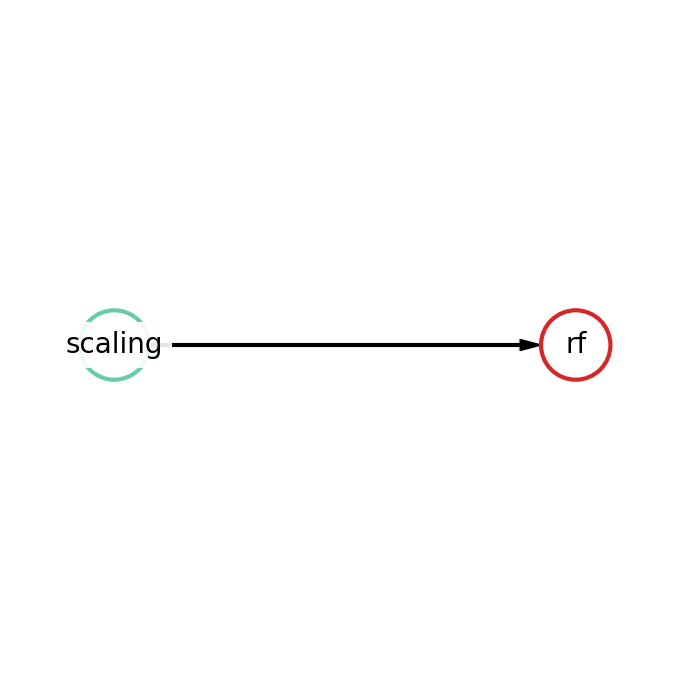

In [23]:
print(model.current_pipeline)

model.current_pipeline.show(node_size_scale=0.5)

In [24]:
labels = industrial.predict(test_features=test_data[0],
                            test_target=test_data[1])

probs = industrial.predict_proba(test_features=test_data[0],
                                 test_target=test_data[1])

print(labels)

2023-06-09 14:02:09,947 - Trying to load features from cache


Components processed: 100%|██████████| 38/38 [00:01<00:00, 22.31ts/s]

2023-06-09 14:02:11,699 - Caching features
2023-06-09 14:02:11,706 - Trying to load features from cache



100%|██████████| 38/38 [00:01<00:00, 35.79it/s]

2023-06-09 14:02:12,772 - Caching features
2023-06-09 14:02:12,776 - Trying to load features from cache



Components processed: 100%|██████████| 38/38 [00:00<00:00, 63.32ts/s]

2023-06-09 14:02:13,421 - Caching features
2023-06-09 14:02:13,426 - Trying to load features from cache



100%|██████████| 38/38 [00:00<00:00, 106.64it/s]

2023-06-09 14:02:13,788 - Caching features
2023-06-09 14:02:13,791 - Trying to load features from cache



Components processed: 100%|██████████| 38/38 [00:00<00:00, 53.82ts/s]

2023-06-09 14:02:14,545 - Caching features
2023-06-09 14:02:14,550 - Trying to load features from cache



100%|██████████| 38/38 [00:01<00:00, 28.16it/s]

2023-06-09 14:02:15,904 - Caching features


[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]]


In [25]:
print(probs)

[[0.10185714]
 [0.27102381]
 [0.27102381]
 [0.60333333]
 [0.24719048]
 [0.50102381]
 [0.95616667]
 [0.632     ]
 [0.53102381]
 [0.87583333]
 [0.23719048]
 [0.56135714]
 [0.27102381]
 [0.60333333]
 [0.27102381]
 [0.89333333]
 [0.27102381]
 [0.89583333]
 [0.53102381]
 [0.52685714]
 [0.20852381]
 [0.17685714]
 [0.20852381]
 [0.632     ]
 [0.22685714]
 [0.89583333]
 [0.17469048]
 [0.26552381]
 [0.27102381]
 [0.96866667]
 [0.632     ]
 [0.53102381]
 [0.54935714]
 [0.54083333]
 [0.20435714]
 [0.22685714]
 [0.23719048]
 [0.92583333]]


In [26]:
from sklearn.metrics import classification_report

print(classification_report(test_data[1], labels))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        19
           1       0.75      0.79      0.77        19

    accuracy                           0.76        38
   macro avg       0.76      0.76      0.76        38
weighted avg       0.76      0.76      0.76        38

